# cv2.dnn.readNetFromCaffe

In [ ]:
# ls 'drive/MyDrive/openpose2/images/'

In [ ]:
ls 'drive/MyDrive/openpose2/images/images2.jpg'

drive/MyDrive/openpose2/images/images2.jpg


time taken by network : 6.907
Raw points (without normalization to neck being the origin):


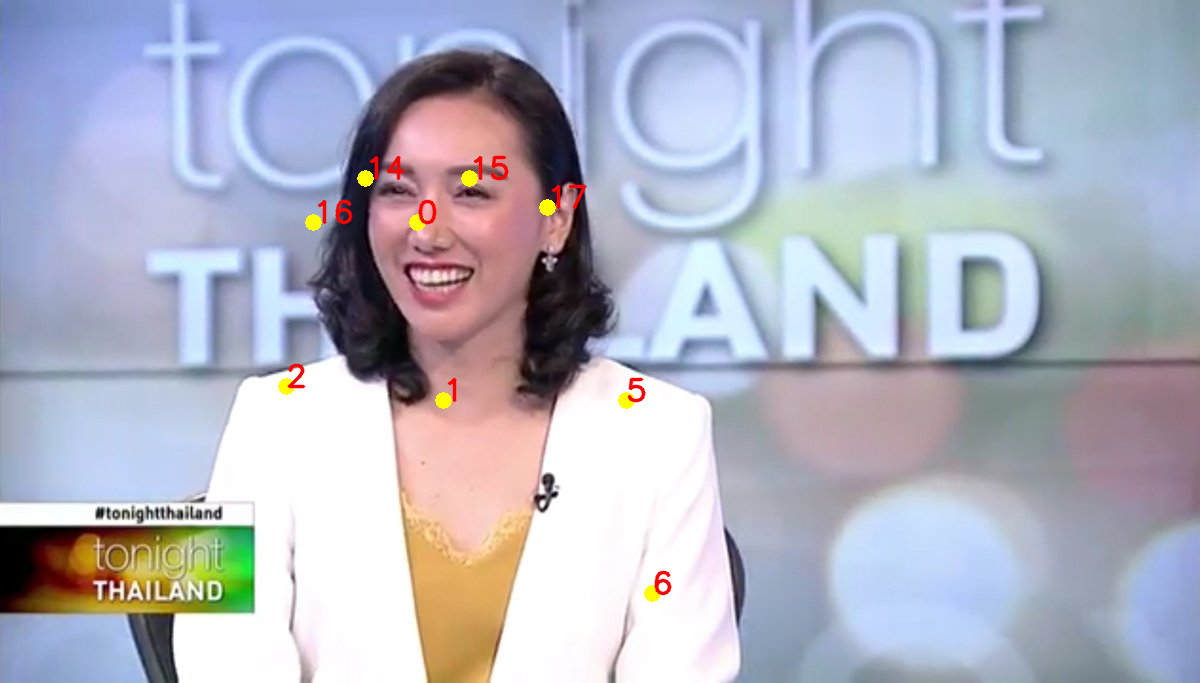

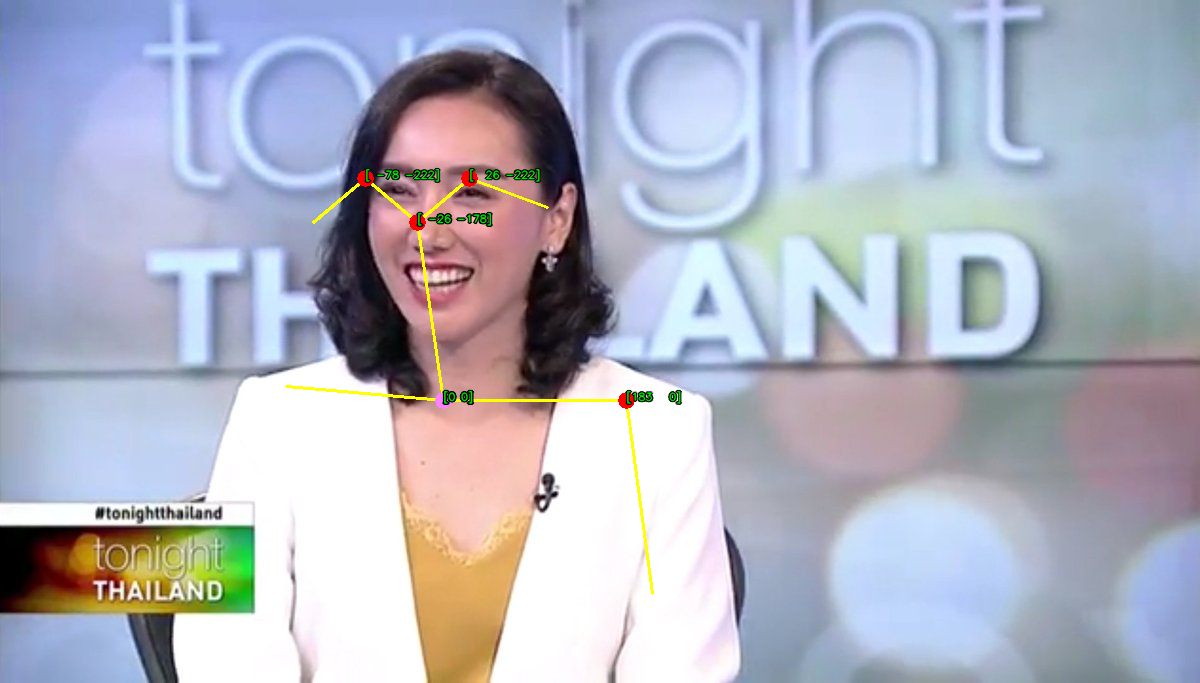

Total time taken : 7.483


-1

In [ ]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow

MODE = "COCO"

if MODE is "COCO":
    protoFile = "drive/MyDrive/openpose2/pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "drive/MyDrive/openpose2/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "drive/MyDrive/openpose2/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "drive/MyDrive/openpose2/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]


frame = cv2.imread("drive/MyDrive/openpose2/images/images2.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

t = time.time()
# input image dimensions for the network
inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

H = output.shape[2]
W = output.shape[3]

# Empty list to store the detected keypoints
points = []


for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

font = cv2.FONT_HERSHEY_SIMPLEX
# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]
    cv2.circle(frame, points[1], 8, (255, 128, 255), thickness=-1, lineType=cv2.FILLED)

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
        cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
	

for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.putText(frame, str(np.subtract(points[partA],points[1])), points[partA], font, 0.35, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(frame, str(np.subtract(points[partA],points[1])), points[partA], font, 0.35, (0,255,0), 1, cv2.LINE_AA)

print('Raw points (without normalization to neck being the origin):')
# print(points)
cv2_imshow(frameCopy)
cv2_imshow(frame)

# flat_points = [item for sublist in points for item in sublist]
# np.savez('features_generated.npz', features=flat_points)

cv2.imwrite('Output-Keypoints.jpg', frameCopy)
cv2.imwrite('Output-Skeleton.jpg', frame)

print("Total time taken : {:.3f}".format(time.time() - t))
cv2.waitKey(0)